In [1]:
import numpy as np
from tqdm import tqdm ## Tqdm is a Python library that provides fast, extensible progress bars for loops and iterable
from skimage.io import imread
from skimage.transform import resize
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Cropping2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, load_img, img_to_array
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
seed = 42
np.random.seed = seed

### Data Preprocessing 

In [2]:
import os
import numpy as np
from keras.preprocessing.image import load_img, img_to_array

def load_images(image_dir, mask_dir, image_size=(128, 128)):
    images = []
    masks = []

    for filename in sorted(os.listdir(image_dir)):
        img_path = os.path.join(image_dir, filename)
        
        # Adjust the mask filename pattern to match actual file names in mask_dir
        mask_filename = filename.replace('img', 'mask')  # Adjust as needed based on naming convention
        mask_path = os.path.join(mask_dir, mask_filename)
        
        # Check if both the image and corresponding mask exist
        if not os.path.exists(img_path):
            print(f"Image not found: {img_path}")
            continue
        if not os.path.exists(mask_path):
            print(f"Mask not found for image '{filename}': {mask_path}")
            continue

        # Load and resize images and masks
        img = load_img(img_path, color_mode='grayscale')
        img = img.resize(image_size)  # Resize to target size
        mask = load_img(mask_path, color_mode='grayscale')
        mask = mask.resize(image_size)  # Resize to target size
        
        # Convert to numpy arrays and normalize
        images.append(img_to_array(img) / 255.0)
        masks.append(img_to_array(mask) / 255.0)
    
    return np.array(images), np.array(masks)

# Load and verify sizes
base_path = "dataset_2"
image_dir = os.path.join(base_path, 'original_gray')
mask_dir = os.path.join(base_path, 'roi_masks')

images, masks = load_images(image_dir, mask_dir)

print("Number of images loaded:", len(images))
print("Image shape:", images[0].shape if len(images) > 0 else "No images loaded")
print("Number of masks loaded:", len(masks))
print("Mask shape:", masks[0].shape if len(masks) > 0 else "No masks loaded")

Number of images loaded: 87
Image shape: (128, 128, 1)
Number of masks loaded: 87
Mask shape: (128, 128, 1)


### Let's check the images before training the model 

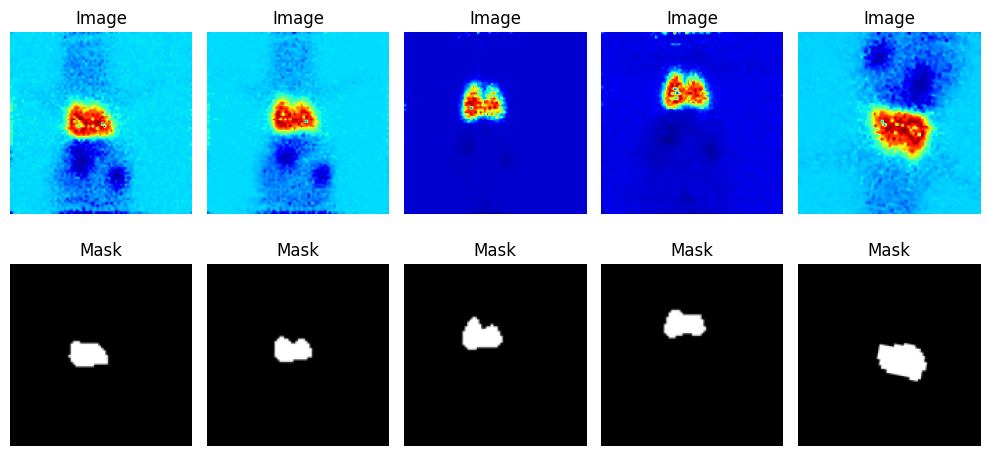

In [4]:
# Visualize some images and masks
def visualize_samples(images, masks, num_samples=5):
    plt.figure(figsize=(10, 5))
    for i in range(num_samples):
        if i >= len(images):
            break
        # Display image
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(images[6*i].squeeze(), cmap='jet')
        plt.axis('off')
        plt.title("Image")
        
        # Display mask
        plt.subplot(2, num_samples, num_samples + i + 1)
        plt.imshow(masks[6*i].squeeze(), cmap='gray')
        plt.axis('off')
        plt.title("Mask")
    
    plt.tight_layout()
    plt.show()

visualize_samples(images, masks)

In [11]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Create directories for training and validation data
train_dir = 'dataset/train'
test_dir = 'dataset/test'

# Create subdirectories for images and masks
train_img_dir = os.path.join(train_dir, 'images')
train_mask_dir = os.path.join(train_dir, 'masks')
test_img_dir = os.path.join(test_dir, 'images')
test_mask_dir = os.path.join(test_dir, 'masks')

# Create the directories
os.makedirs(train_img_dir, exist_ok=True)
os.makedirs(train_mask_dir, exist_ok=True)
os.makedirs(test_img_dir, exist_ok=True)
os.makedirs(test_mask_dir, exist_ok=True)

# Get list of files
images = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
masks = [os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=42)

# Copy the images and masks to their respective directories
for img, mask in zip(X_train, y_train):
    shutil.copy(img, os.path.join(train_img_dir, os.path.basename(img)))
    shutil.copy(mask, os.path.join(train_mask_dir, os.path.basename(mask)))

for img, mask in zip(X_test, y_test):
    shutil.copy(img, os.path.join(test_img_dir, os.path.basename(img)))
    shutil.copy(mask, os.path.join(test_mask_dir, os.path.basename(mask)))

In [12]:
# Define a function to load images from file paths
def load_images(image_paths, target_size=(128, 128), color_mode='grayscale'):
    images = []
    for path in image_paths:
        img = load_img(path, target_size=target_size, color_mode=color_mode)  # Load image
        img_array = img_to_array(img) / 255.0  # Convert to array and normalize
        images.append(img_array)
    return np.array(images)

# Preprocess the training and mask data
X_train = load_images(X_train)  # Replace X_train (file paths) with actual image data
y_train = load_images(y_train)  # Replace y_train (file paths) with actual mask data

X_test = load_images(X_test)
y_test= load_images(y_test)

### Building the U-net Model

In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout, Activation, Add, Multiply, UpSampling2D
from tensorflow.keras.models import Model

def attention_block(x, g, inter_channel):
    theta_x = Conv2D(inter_channel, (1, 1), padding='same')(x)
    phi_g = Conv2D(inter_channel, (1, 1), padding='same')(g)
    add_xg = Add()([theta_x, phi_g])
    act_xg = Activation('relu')(add_xg)
    psi = Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = Activation('sigmoid')(psi)
    return Multiply()([x, sigmoid_xg])

def build_attention_unet(input_shape):
    inputs = Input(input_shape)
    
    def encoder_block(inputs, num_filters, dropout_rate):
        x = Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
        x = Dropout(dropout_rate)(x)
        x = Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        return x

    def decoder_block(inputs, skip_features, num_filters, dropout_rate):
        x = Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(inputs)
        attn = attention_block(skip_features, x, num_filters // 2)
        x = concatenate([x, attn])
        x = Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        x = Dropout(dropout_rate)(x)
        x = Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        return x

    c1 = encoder_block(inputs, 16, 0.1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = encoder_block(p1, 32, 0.1)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = encoder_block(p2, 64, 0.2)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = encoder_block(p3, 128, 0.2)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = encoder_block(p4, 256, 0.3)

    u6 = decoder_block(c5, c4, 128, 0.2)
    u7 = decoder_block(u6, c3, 64, 0.2)
    u8 = decoder_block(u7, c2, 32, 0.1)
    u9 = decoder_block(u8, c1, 16, 0.1)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(u9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Build and compile the Attention U-Net model
# X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)
input_shape = (None, None, 1)  # Adjust based on your input data
model = build_attention_unet(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# model.summary()

 Model fit takes X and y and have some other functions --- such callbacks ---  tf.keras.callbackshttps://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint 
in callbacks you can check weights at every epoch, save best results, early stopping and so many others --

In [14]:
print(X_train.shape)

(69, 128, 128, 1)


In [15]:
### Model checkpoint

checkpointer = tf.keras.callbacks.ModelCheckpoint('attention_model_for_rats.keras', verbose = 1, save_best_only = True )

callbacks =  [tf.keras.callbacks.EarlyStopping(patience = 10, monitor = 'val_loss'),
            tf.keras.callbacks.TensorBoard(log_dir = 'logs')]

results = model.fit(X_train, y_train , validation_split = 0.1 , batch_size = 4, epochs = 25, callbacks = callbacks)

Epoch 1/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 264ms/step - accuracy: 0.7989 - loss: 0.4973 - val_accuracy: 0.9674 - val_loss: 0.2421
Epoch 2/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 212ms/step - accuracy: 0.9670 - loss: 0.1245 - val_accuracy: 0.9674 - val_loss: 0.1291
Epoch 3/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 196ms/step - accuracy: 0.9684 - loss: 0.0782 - val_accuracy: 0.9674 - val_loss: 0.1608
Epoch 4/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 196ms/step - accuracy: 0.9653 - loss: 0.0816 - val_accuracy: 0.9674 - val_loss: 0.0511
Epoch 5/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step - accuracy: 0.9649 - loss: 0.0648 - val_accuracy: 0.9674 - val_loss: 0.0567
Epoch 6/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step - accuracy: 0.9641 - loss: 0.0596 - val_accuracy: 0.9674 - val_loss: 0.0554
Epoch 7/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 201ms/step - accuracy: 0.9683 - loss: 0.0374 - val_accuracy: 0.9674 - val_loss: 0.0398
Epoch 8/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step - accuracy: 0.9666 - loss: 0.0403 - val_accuracy: 0

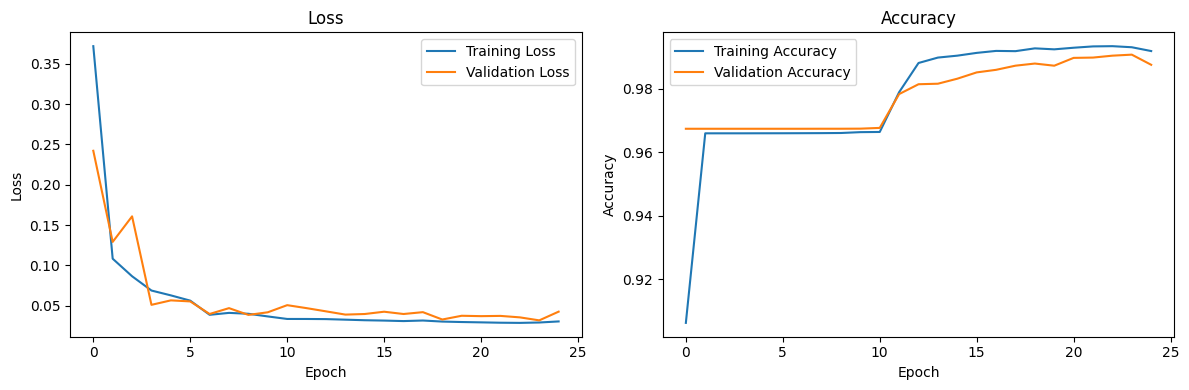

In [16]:
import matplotlib.pyplot as plt

# Extract metrics from the history object
history = results.history

# Plot Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy (if applicable)
if 'accuracy' in history:
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

plt.tight_layout()
plt.show()

In [17]:
model.save('new_attunet.h5')

In [18]:
# Get the best and last values of the training accuracy
best_train_acc = max(history['accuracy'])
last_train_acc = history['accuracy'][-1]

# Get the best and last values of the validation accuracy
best_val_acc = max(history['val_accuracy'])
last_val_acc = history['val_accuracy'][-1]

# Get the best and last values of the training loss
best_train_loss = min(history['loss'])
last_train_loss = history['loss'][-1]

# Get the best and last values of the validation loss
best_val_loss = min(history['val_loss'])
last_val_loss = history['val_loss'][-1]

# Print the results
print("Best Training Accuracy: ", best_train_acc)
print("Last Training Accuracy: ", last_train_acc)
print("Best Validation Accuracy: ", best_val_acc)
print("Last Validation Accuracy: ", last_val_acc)
print("Best Training Loss: ", best_train_loss)
print("Last Training Loss: ", last_train_loss)
print("Best Validation Loss: ", best_val_loss)


Best Training Accuracy:  0.9934554696083069
Last Training Accuracy:  0.9919148087501526
Best Validation Accuracy:  0.99078369140625
Last Validation Accuracy:  0.9875836968421936
Best Training Loss:  0.02873498946428299
Last Training Loss:  0.030533738434314728
Best Validation Loss:  0.03186078369617462


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 966ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


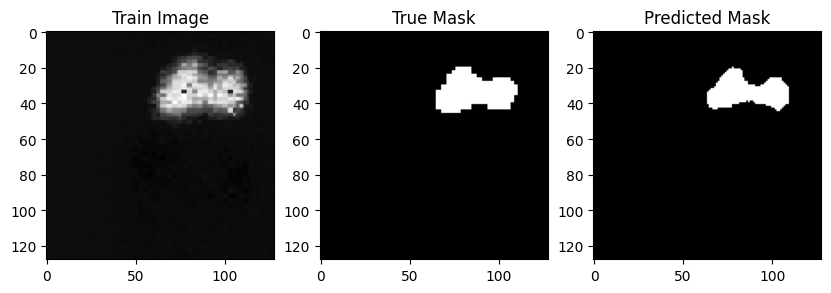

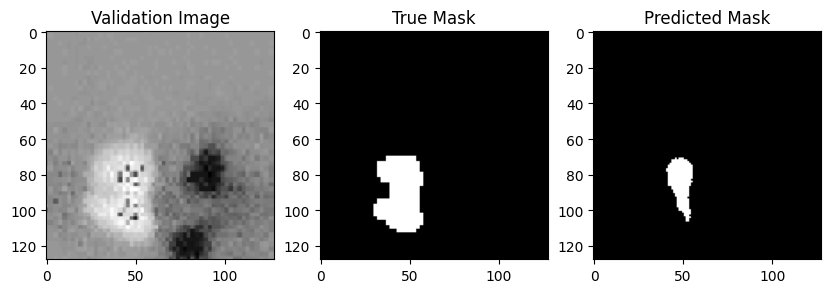

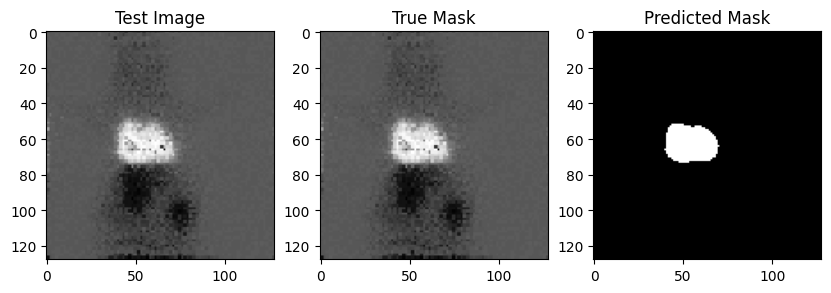

In [19]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Generate predictions for the datasets
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold the predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Define datasets and titles
datasets = [
    (X_train, y_train, preds_train_t, "Train Image"),
    (X_train[int(X_train.shape[0]*0.9):], y_train[int(y_train.shape[0]*0.9):], preds_val_t, "Validation Image"),
    (X_test, X_test, preds_test_t, "Test Image")
]

# Loop through each dataset
for X, y, preds, title_prefix in datasets:
    ix = random.randint(0, len(preds) - 1)
    plt.figure(figsize=(10, 3))
    
    plt.subplot(1, 3, 1)
    plt.title(f"{title_prefix}")
    plt.imshow(X[ix].squeeze(), cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title("True Mask")
    plt.imshow(y[ix].squeeze(), cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(preds[ix].squeeze(), cmap='gray')
    
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


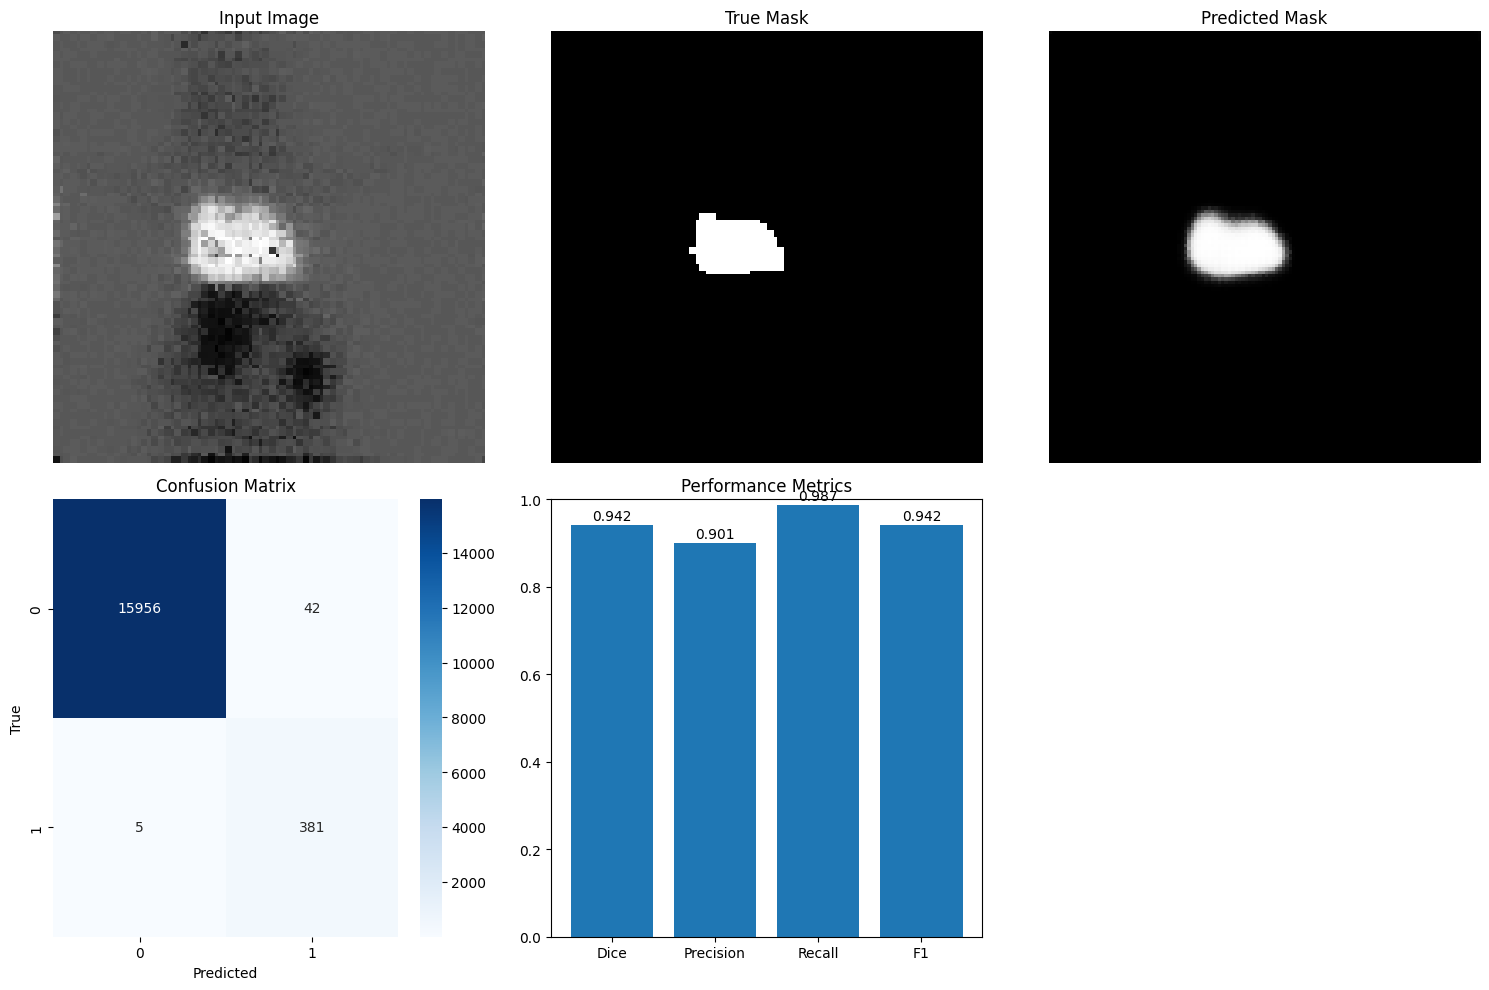

In [15]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

# Load model and predict as before
img_path = "dataset_2/original_gray/img_001.png"
img = load_img(img_path, color_mode='grayscale', target_size=(128, 128))
img_array = img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)
new_predictions = model.predict(img_array)
predicted_mask = new_predictions[0].squeeze()

# Load ground truth mask
mask_path = "dataset_2/roi_masks/mask_001.png" # Assuming this is the corresponding mask path
true_mask = load_img(mask_path, color_mode='grayscale', target_size=(128, 128))
true_mask = img_to_array(true_mask) / 255.0
true_mask = true_mask.squeeze()

# Threshold predictions to binary
predicted_mask_binary = (predicted_mask > 0.5).astype(np.uint8)
true_mask_binary = (true_mask > 0.5).astype(np.uint8)

# Calculate metrics
conf_matrix = confusion_matrix(true_mask_binary.flatten(), predicted_mask_binary.flatten())
precision = precision_score(true_mask_binary.flatten(), predicted_mask_binary.flatten())
recall = recall_score(true_mask_binary.flatten(), predicted_mask_binary.flatten())
f1 = f1_score(true_mask_binary.flatten(), predicted_mask_binary.flatten())

# Calculate Dice coefficient
def dice_coef(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred)
    return (2. * intersection) / (union + 1e-7)

dice = dice_coef(true_mask_binary, predicted_mask_binary)

# Visualization
plt.figure(figsize=(15, 10))

# Original image and predictions
plt.subplot(2, 3, 1)
plt.title("Input Image")
plt.imshow(img_array[0].squeeze(), cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.title("True Mask")
plt.imshow(true_mask, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.title("Predicted Mask")
plt.imshow(predicted_mask, cmap='gray')
plt.axis('off')

# Confusion Matrix
plt.subplot(2, 3, 4)
plt.title("Confusion Matrix")
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')

# Metrics Bar Plot
plt.subplot(2, 3, 5)
metrics = ['Dice', 'Precision', 'Recall', 'F1']
values = [dice, precision, recall, f1]
plt.bar(metrics, values)
plt.title("Performance Metrics")
plt.ylim(0, 1)
for i, v in enumerate(values):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━

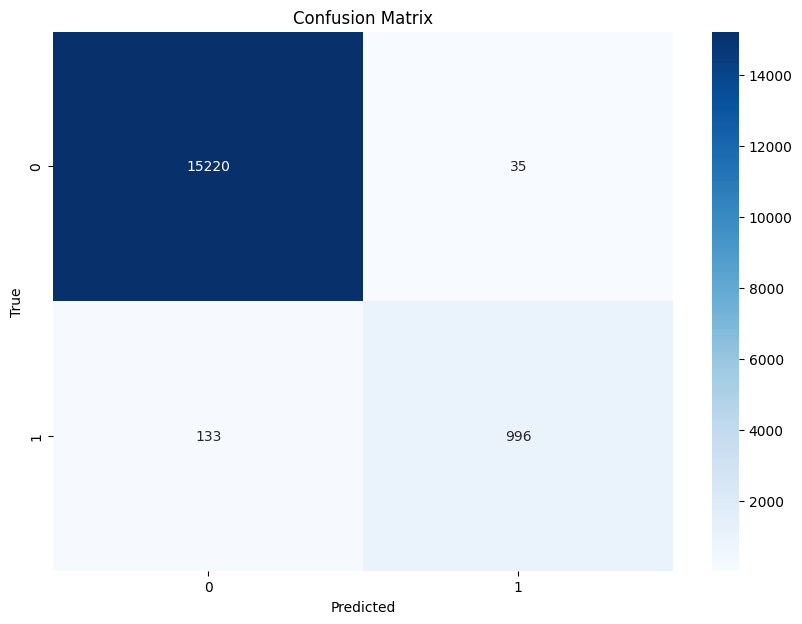

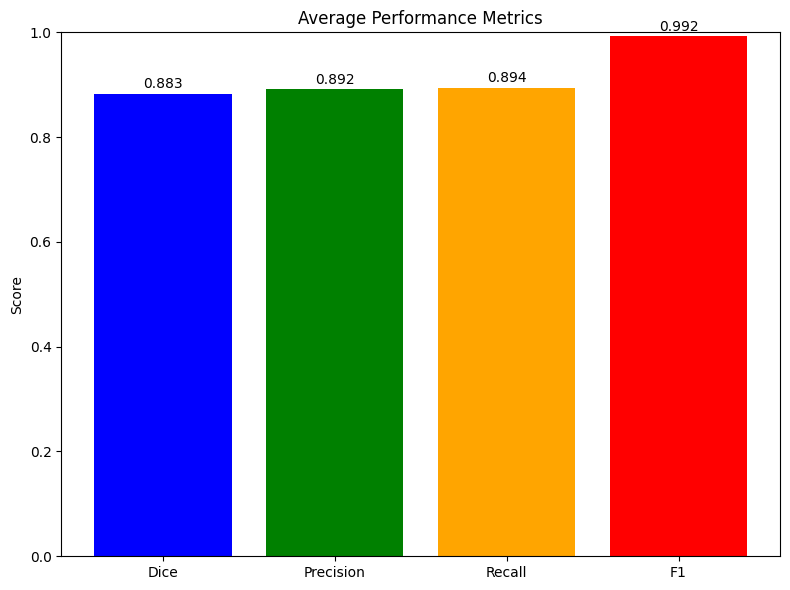

In [21]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score

# Load the trained model
model = load_model('new_attunet.h5')

# Define test directories
test_img_dir = 'dataset/test/images'
test_mask_dir = 'dataset/test/masks'

# Get list of test images and masks
test_images = sorted([os.path.join(test_img_dir, f) for f in os.listdir(test_img_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
test_masks = sorted([os.path.join(test_mask_dir, f) for f in os.listdir(test_mask_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])

# Initialize metrics
dice_scores = []
precisions = []
recalls = []
accuracy_scores = []

# Dice coefficient function
def dice_coef(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred)
    return (2. * intersection) / (union + 1e-7)

# Loop through all test images
for img_path, mask_path in zip(test_images, test_masks):
    # Load and preprocess the test image
    img = load_img(img_path, color_mode='grayscale', target_size=(128, 128))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict the mask
    new_predictions = model.predict(img_array)
    predicted_mask = new_predictions[0].squeeze()

    # Load and preprocess the ground truth mask
    true_mask = load_img(mask_path, color_mode='grayscale', target_size=(128, 128))
    true_mask = img_to_array(true_mask) / 255.0
    true_mask = true_mask.squeeze()

    # Threshold predictions and ground truth to binary
    predicted_mask_binary = (predicted_mask > 0.5).astype(np.uint8)
    true_mask_binary = (true_mask > 0.5).astype(np.uint8)

    # Calculate metrics for the current image
    dice = dice_coef(true_mask_binary, predicted_mask_binary)
    precision = precision_score(true_mask_binary.flatten(), predicted_mask_binary.flatten())
    recall = recall_score(true_mask_binary.flatten(), predicted_mask_binary.flatten())
    f1 = accuracy_score(true_mask_binary.flatten(), predicted_mask_binary.flatten())

    # Append metrics to the lists
    dice_scores.append(dice)
    precisions.append(precision)
    recalls.append(recall)
    accuracy_scores.append(f1)

# Calculate average metrics
avg_dice = np.mean(dice_scores)
avg_precision = np.mean(precisions)
avg_recall = np.mean(recalls)
avg_f1 = np.mean(accuracy_scores)

# Print average metrics
print(f"Average Dice Coefficient: {avg_dice:.3f}")
print(f"Average Precision: {avg_precision:.3f}")
print(f"Average Recall: {avg_recall:.3f}")
print(f"Average F1 Score: {avg_f1:.3f}")

# Plot confusion matrix for one example image (optional)
conf_matrix = confusion_matrix(true_mask_binary.flatten(), predicted_mask_binary.flatten())
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Bar plot of average metrics
metrics = ['Dice', 'Precision', 'Recall', 'F1']
values = [avg_dice, avg_precision, avg_recall, avg_f1]

plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['blue', 'green', 'orange', 'red'])
plt.title("Average Performance Metrics")
plt.ylim(0, 1)
for i, v in enumerate(values):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center')
plt.ylabel("Score")
plt.tight_layout()
plt.show()